# Summer temperature anomaly aggregat by country, region, etc


In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns

from tqdm import tqdm

from config import DATA_SRC, POP_DATA_SRC, WEATHER_SRC

In [3]:
# Figure settings
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.figsize'] = (5,2.5)
plt.rcParams['figure.titlesize'] = 'medium'
plt.rcParams['axes.titlesize'] = 'medium'
plt.rcParams['savefig.bbox'] = 'tight'

In [4]:
MAX_YEAR = 2020
REFERENCE_YEAR_START = 1986
REFERENCE_YEAR_END = 2005

RESULTS_FOLDER = Path('../results/summer temperature change/').absolute()

INTERMEDIATE_RESULTS_FOLDER = DATA_SRC / 'lancet'/ 'summer_temperature'/ 'results_2021'

GPW_FILE = DATA_SRC/ 'lancet/population/UN WPP-Adjusted Population Count v4.11 2000-2020 15min era compat.nc'
POPULATION_VAR = 'UN WPP-Adjusted Population Count, v4.11 (2000-2020)'

COUNTRY_ID_LOOKUP = DATA_SRC/ 'lancet/population/gpwv4/gpw_v4_national_identifier_lookup.txt'
# COUNTRY_RASTER_FILES = DATA_SRC/ 'lancet/population/country_codes_30min_era_compat.nc'

## Load the population data

In [4]:
gpw_ds = xr.open_dataset(GPW_FILE)

In [5]:
population = gpw_ds[POPULATION_VAR]

## Load country data

In [6]:
COUNTRIES_RASTER = gpw_ds['National Identifier Grid, v4.11 (2010): National Identifier Grid'].load()

In [7]:
COUNTRIES_LOOKUP = pd.read_csv(COUNTRY_ID_LOOKUP,sep='\t')

In [8]:
COUNTRIES_LOOKUP.head()

GRIDCODE ISOCODE  UNSDCODE           NAME0  CIESINCODE  \
0         4     AFG         4     Afghanistan           4   
1         8     ALB         8         Albania           8   
2        12     DZA        12         Algeria          12   
3        16     ASM        16  American Samoa          16   
4        20     AND        20         Andorra          20   

                         DATATYPE  DATACODE  DATAYEAR  DATALEVEL  GRSTART  \
0  Population estimate/projection         6      2011          2     1998   
1                    Final census         1      2011          3     2001   
2                    Final census         1      2008          2     1998   
3                    Final census         1      2010          3     2000   
4             Population register         5      2010          1     2000   

   GREND  GRLEVEL  LASTCENSUS    MEANUNITKM  
0   2011        1        1979   4507.466751  
1   2011        3        2011    115.949835  
2   2008        2        2008  50884.794880  
3   2010        3        2010      7.612468  
4   2010        1        2011     79.902822

## Load Lancet standardisation data

In [9]:
SD_FOLDER = Path('../../Standardisation guidelines - LIVE FOR AUTHORS')

In [10]:
country_classification = pd.read_excel(SD_FOLDER / 'Country names - ISO3 codes - WHO and HDI classifications2021.xlsx', skiprows=1)

In [11]:
country_classification

Preferred Country Name ISO ALPHA-3 code       WHO Region  \
0                    Aruba              ABW              NaN   
1                   Angola              AGO          African   
2                  Burundi              BDI          African   
3                    Benin              BEN          African   
4             Burkina Faso              BFA          African   
..                     ...              ...              ...   
193                  Tonga              TON  Western Pacific   
194                 Tuvalu              TUV  Western Pacific   
195                Vietnam              VNM  Western Pacific   
196                Vanuatu              VUT  Western Pacific   
197                  Samoa              WSM  Western Pacific   

    Level of human development Human Development Index in 2018 (HDI)  HDI rank  
0                          NaN                                   NaN       NaN  
1                       Medium                              0.574488     149.0  
2                          Low                              0.422882     185.0  
3                          Low                              0.519834     163.0  
4                          Low                              0.433547     182.0  
..                         ...                                   ...       ...  
193                       High                               0.71743     105.0  
194                        NaN                                    ..       NaN  
195                     Medium                              0.692669     118.0  
196                     Medium                              0.596848     141.0  
197                       High                              0.706771     111.0  

[198 rows x 6 columns]

In [12]:
world_map_data = gpd.read_file(SD_FOLDER/ 'Shapefiles' / 'detailed_2013.shp').set_index('ISO_3_CODE')

In [27]:
world_map_data = world_map_data.join(country_classification.set_index('ISO ALPHA-3 code'))

## Load region raster references

In [13]:
who_regions = xr.open_dataarray(POP_DATA_SRC / 'who_regions_15min_era_compat.nc')

In [14]:
hdi_regions = xr.open_dataarray(POP_DATA_SRC / 'hdi_regions_15min_era_compat.nc')

## Exposure weighted change by country

In [20]:
# weighted_results= pd.read_csv(INTERMEDIATE_RESULTS_FOLDER / 'weighted_change_by_country.csv')

In [16]:
results_by_country = pd.read_csv(RESULTS_FOLDER / 'weighted_change_by_country_long.csv')

In [29]:
results_by_country

ISO ALPHA-3 code  year  Exposure weighted change K
0                 ABW  2000                   -0.234387
1                 ABW  2001                   -0.183457
2                 ABW  2002                   -0.023418
3                 ABW  2003                   -0.038707
4                 ABW  2004                   -0.033211
...               ...   ...                         ...
5203              ZWE  2016                    1.554110
5204              ZWE  2017                   -0.029885
5205              ZWE  2018                    0.537388
5206              ZWE  2019                    1.228587
5207              ZWE  2020                    0.393087

[5208 rows x 3 columns]

## Exposure weighted by WHO region

In [6]:
results_by_who_region = pd.read_csv(RESULTS_FOLDER / 'summer_warming_weighted_change_by_who_region.csv')

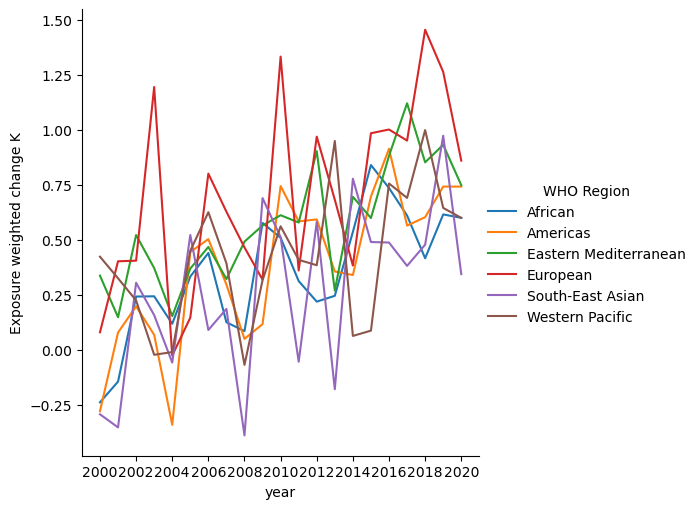

In [20]:
sns.relplot(kind='line', data=results_by_who_region, x='year', y='Exposure weighted change K', hue='WHO Region')
plt.xticks(np.arange(2000,2022, 2))

plt.savefig(RESULTS_FOLDER / 'summer_warming_weighted_change_by_who_region.png')

## Exposure weighted by Human Development Index class


In [7]:
results_by_hdi_region = pd.read_csv(RESULTS_FOLDER / 'summer_warming_weighted_change_by_hdi_region.csv')

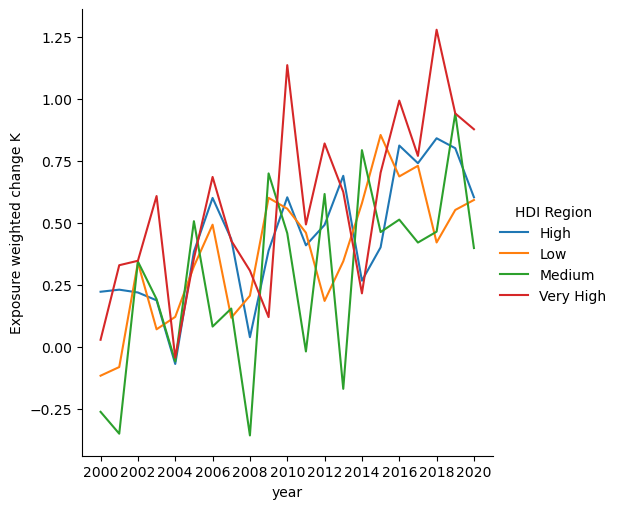

In [19]:
sns.relplot(kind='line', data=results_by_hdi_region, x='year', y='Exposure weighted change K', hue='HDI Region')
plt.xticks(np.arange(2000,2022, 2))
plt.savefig(RESULTS_FOLDER / 'summer_warming_weighted_change_by_hdi_region.png')

In [36]:
plot_data = world_map_data.join(results_by_country[results_by_country.year==2020].set_index('ISO ALPHA-3 code'))

<AxesSubplot:>

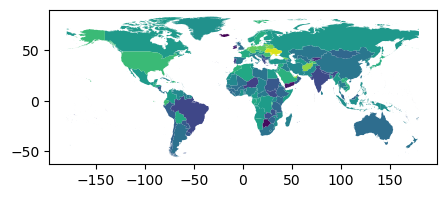

In [37]:
plot_data.plot(column='Exposure weighted change K')